# Variational Classifier

The original tutorial for this notebook can be found here: https://pennylane.ai/qml/demos/tutorial_variational_classifier/



## Intro

### Variational Quantum Classifiers (VQCs)

Variational Quantum Classifiers (VQCs) are a type of hybrid quantum machine learning algorithm that combines the power of quantum computing with the flexibility of classical machine learning algorithms to achieve state-of-the-art performance on a wide range of classification tasks.
They are a class of quantum algorithms that use a variational approach to optimize a quantum circuit for a specific machine learning task, and have been shown to be effective in a variety of applications, including image classification, natural language processing, and more.

### How VQCs Work

A VQC consists of two parts: a classical part for pre- and post-processing data, and a quantum part for harnessing the power of quantum mechanics to perform certain calculations more efficiently. The quantum part is composed of a quantum circuit that behaves similarly to a traditional machine learning algorithm and these are done by some steps


#### Step 1: Encode Classical Data into a Quantum State

To encode classical data into a quantum state, we perform certain operations to help us work with the data in quantum circuits. One of the steps is called data embedding, which is the representation of classical data as a quantum state in Hilbert space via a quantum feature map.

Angle Encoding: One common method is angle encoding, where classical features are mapped to the angles of rotation gates applied to qubits.
Example: For a data vector
$x$ with features $x_1, x_2, ... x_n$, we encode these features into quantum states using rotation gates. If we have a qubit, we apply a rotation
$Rx(\theta)$ where \
$\theta = x*i*\textrm{scaling factor} $. \
The quantum state
$|\psi⟩$ is then prepared as: \
$|\psi⟩ = Rx(\theta_1) Ry(\theta_2) ... Rz(\theta_n)|0⟩$. \
Here, $|0⟩$ is the initial state of the qubit, and $Rx, Ry, Rz$ are rotation operators applied to the qubit.

#### Step 2: Input Data into a Quantum Circuit

After encoding, a parameterized quantum circuit processes the quantum state. The circuit consists of various quantum gates such as Hadamard, CNOT, and rotation gates. The parameters of these gates are optimized during training.
Quantum State Evolution: The quantum state evolves according to the unitary transformations defined by the quantum circuit. If $U(\theta)$ represents the unitary operation parameterized by $\theta$, the state after applying the circuit is:
$|\psi(\theta)⟩ = U(\theta)|\psi⟩$ where $|\psi⟩$ is the encoded state.

#### Step 3: Apply a Parameterized Model

The goal of the training phase is to find a set of parameters that maximizes the accuracy of the classification model. In the classifying phase, the encoded quantum state will evolve through the well-trained ansatz $W(\theta)$ with optimized variational parameters $\theta$.

**The Cost Function and Measurement:**

The cost function measures how well the quantum classifier performs. It typically involves:

Expectation Value:

Quantum measurements provide expectation values that are used to estimate probabilities. For a quantum observable ${\hat{O}}$, the expectation value is given by:
$⟨\psi(\theta)|{\hat{O}}|\psi(\theta)⟩$.
This value represents the probability of measuring a particular outcome related to the observable ${\hat{O}}$.

The loss function (or cost function) quantifies the difference between the predicted and true labels. For classification tasks, the cross-entropy loss is often used.

#### Step 4: Parameter Optimization

The goal is to find the optimal parameters $\theta$ that minimize the cost function. This is typically done using classical optimization techniques.
Gradient-Based Optimization: Gradients of the cost function with respect to the parameters $\theta$ are computed to update the parameters. This can be done using methods like gradient descent or more advanced algorithms.

Parameter Shift Rule: A common method to compute gradients in quantum circuits is the parameter shift rule. For a parameterized gate $U(\theta)$, the derivative of the cost function $L(\theta)$ with respect to $\theta$ can be estimated as:
$\delta L(\theta)\delta\theta \approx L(\theta+\delta) - L(\theta-\delta)2\delta$ \
where $\delta$ is a small shift value.



**Training:**

The optimization algorithm iteratively adjusts the parameters to minimize the cost function. This process continues until convergence.

**Now we will do these steps using VQCs with a real world data**

In this notebook, we will reference a few different datasets it some of the code blocks below. These datasets can be found in the "variational_classifier/data" folder, which is also in this repo.

## 1. Fitting the parity function

## Setup

Uncomment the line below to install pennylane if it is not already on your machine.

In [50]:
# !pip install pennylane

##Imports

In [18]:
# PennyLane import
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

# MatPlotLib import
import matplotlib.pyplot as plt

##Defining the Quantum Circuit

We will begin by creating a quantum device on which to run our circuits.

In [19]:
# Set up the quantum device (PennyLane simulator in our case)
dev = qml.device("default.qubit", wires=4)

##Defining the Variational Quantum Classifier

In [ ]:
# Define the variational classifier function
def variational_classifier(weights, x):
    return circuit(weights, x)

##Quantum and Classical Nodes


Variational classifiers define an elementary circuit architecture that gets repeated to build the full variational circuit as a "layer" or "block".

The circuit we demonstrate in this tutorial will be composed of four qubits (referred to as "wires" in the code) and will also consist of an arbitrary rotation on each qubit/"wire", accompanied by a ring of CNOTs to entangle each qubit with its neighbor. The layers are composed of parameters, which are referred to as "weights".

In [20]:
# Taking in the weights for input, define the layers by applying a rotation of that "weight" to the associated qubit
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    # Apply a "ring" of CNOT gates to entangle the qubits
    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

In addition to these layers and weights, we need a way to encode data inputs into the circuit so that the measured output is dependent upon these inputs. Because the inputs are bitstrings in our first example, we will encode them into the state of qubits. After preparing our states, the quantum state we end up with, $|\psi⟩$, is a computational basis state that has 1s in the same location the bitstring x does:
$x=0101 \rightarrow |\psi⟩=|0101⟩$

PennyLane provides us with a "BasisState" function, which does exactly this, interpreting x as a list of zeros and ones and mapping them to their respective qubits.

In [21]:
# Define BasisState preparation function
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

We define our variational quantum circuit as the state preparation routine defined above, followed by a repetition of the layer structure, factoring in the weight associated with each layer.

In [22]:
# Establish a QNode to be associated with our [simulator] device
@qml.qnode(dev)
# Define circuit function to include state preparation utilizing layer weights and output expectation value
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

To add a "classical" bias parameter to our variational quantum classifier, we'll also add in some post-processing before defining the full model as the sum of the quantum circuit's output, plus the trainable bias.

In [23]:
#  Add bias to our variational classifier
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

## The Cost Function

In supervised learning, the cost function typically combines a loss function with a regularization term. For simplicity, we will focus on the standard squared loss function, which evaluates how far the model's predictions are from the true target labels.

In [24]:
# Define square loss function
def square_loss(labels, predictions):
    # Call qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

Additionally, to evaluate the performance of the classifier, we use accuracy, which measures the percentage of predictions that match the true target labels. Accuracy provides a straightforward metric for assessing how often the classifier correctly identifies the correct class.



In [25]:
# Define accuracy function to calculate difference between labels and model's predictions
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

During the training of our model, the cost function's computation hinges on the specific data used—namely, the features and labels that are processed in each optimization iteration.

In [26]:
# Define cost function
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

##Optimization

Reminder: as mentioned at the beginning of this notebook, the necessary data (the parity dataset's train and test sets) can be found under "variational_classifier/data", which is also in this repo.

In [36]:
data = np.loadtxt("variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


We initialize the variables randomly but fix a seed for reproducibility.

In [37]:
# Set random seed
np.random.seed(0)

# Set up parameters
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


Then  we  need to create an optimizer instance and choose a batch size. (The optimizer we choose and the batch size are parameters that we can also change if we want to test other variations of our model.)

In [38]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

Run the optimizer to train the model and track the accuracy. (Outputs of the variational classifier are converted to predictions in {-1,1} by taking the sign of the output.)


In [39]:
# Initialize weights and bias
weights = weights_init
bias = bias_init

# Iterate 100 times, updating weights in addition to computing cost and accuracy
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.3147651 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9664866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9208589 | Accuracy: 0.5000000
Iter:    4 | Cost: 2.6276126 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.9323119 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1903549 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.0508989 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.1275531 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.1659803 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.1349618 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9994063 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.0812559 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.2863155 | Accuracy: 0.6000000
Iter:   14 | Cost: 2.2658259 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.1323724 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.3439737 | Accuracy: 0.8000000
Iter:   17 | Cost: 2.0076168 | Accuracy: 0.6000000
Iter:   18 | Cost: 1.2685760 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.6762475 | Accuracy: 0.5000000
Iter:   20 | Cost: 1.1868237 | 

We can see that over time (around Iteration #51), the model learned to correctly classify the bitstrings in the training set. This is great, but we want to ensure that our model can generalize well when it comes to new data, instead of fitting the training set perfectly but being unable to accurately predict an output from unseen data.

With this in mind, let's evaluate the performance of our classifier on a separate test set of examples that were not used during training. This will give us a better understanding of how well our model can generalize to new, unseen data.

In [40]:
# Load in test data that model was not trained on
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

# Make predictions on test data
predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

# Compute accuracy
acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


Not only can our model make accurate predictions on our training data, but it can also generalize well when it comes to unseen data.

The encoding strategy used in this tutorial actually creates quantum states from data with no overlap, and so the states created from the test set also have no overlap with the training dataset's states. The variational circuit can learn many functional relations from this kind of representation, but our classifier labels bitstrings according to the parity function, our ground truth.

Now that we've seen what variational circuits can do in our example above, for our next example, we want to test out a different encoding strategy.

##2. Iris classification

We're now going to tackle a more complex classification task using the Iris dataset, where each data point is represented as a 2-dimensional real-valued vector. To prepare this data for our quantum classifier, we'll add some "latent dimensions" to the vectors, allowing us to encode the inputs into a 2-qubit quantum state. This will enable us to explore the capabilities of our variational quantum classifier on a more realistic dataset.

##Quantum and classical nodes

**State Preparation for Real-Valued Vectors**

When working with real-valued vectors, state preparation becomes more intricate compared to representing bitstrings with basis states. Each input x needs to be translated into a set of angles, which are then fed into a small routine for state preparation. To simplify this process, we'll focus on data from the positive subspace, allowing us to ignore signs and avoid additional rotations around the Z-axis.

**Circuit Implementation**

Our circuit is implemented based on the scheme outlined in Möttönen et al. (2004) and Schuld and Petruccione (2018), which is adapted for positive vectors only. Additionally, we've decomposed controlled Y-axis rotations into more basic gates, following the approach described in Nielsen and Chuang (2010).

In [41]:
# Define the function to calculate angles used
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

# Prepare states by applying the gates below to the specified qubits
def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Now we want to test our encoding routine to ensure it works.

In [42]:
# Array for test input
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)

# Defining our test function to apply our state preparation to the angles specified
@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()

# Running the function on our small test input
state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.        0.        0.        0.795036  0.        0.
  0.        0.278265  0.        0.        0.       -0.        0.
  0.        0.      ]


Our encoding method correctly prepared the desired state by computing the correct angles and applying the specified gates.

***Important note from PennyLane*** :
"The default.qubit simulator provides a shortcut to state_preparation with the command qml.StatePrep(x, wires=[0, 1]). On state simulators, this just replaces the quantum state with our (normalized) input. On hardware, the operation implements more sophisticated versions of the routine used above."

Now that we're working with 2-qubit circuits, we need to modify the layer and cost functions to accommodate this change. This update will ensure that our variational quantum circuit is tailored to the new 2-qubit architecture.

In [43]:
# Define the layers by applying rotations dependent upon weight inputs
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

# Define the cost function by which we'll score our level of success
def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

##The data

**Preparing the Iris Dataset**

We load the Iris dataset and preprocess it for our quantum classifier. This involves:
* Adding two "latent dimensions" to each data point to match the quantum state vector size
* Normalizing the data to prevent feature dominance
* Converting inputs to rotation angles using the "get_angles" function

Always keep in mind the problem you are trying to solve before you begin preprocessing. In this case, by omitting the addition of latent dimensions, normalization of our vectors would erase important information about the length of the vectors. As a result, classes that would normally be separated by this feature will be indistinguishable from other classes.

Remember: You can find the Iris dataset in the "variational_classifer/data" subfolder that we've added to this repo for you.

In [45]:
# Load in Iris data
data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# Pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# Normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# The angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


We've transformed the original data into a new set of features, represented as angles. That's why we've renamed the input data X to "features". Now, let's visualize the preprocessing steps and experiment with different dimension combinations (like "dim1" and "dim2"). We'll see that some of these new features still effectively distinguish between classes, while others are less useful for classification.

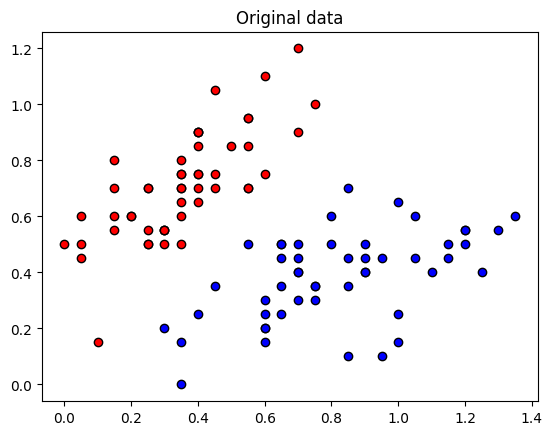

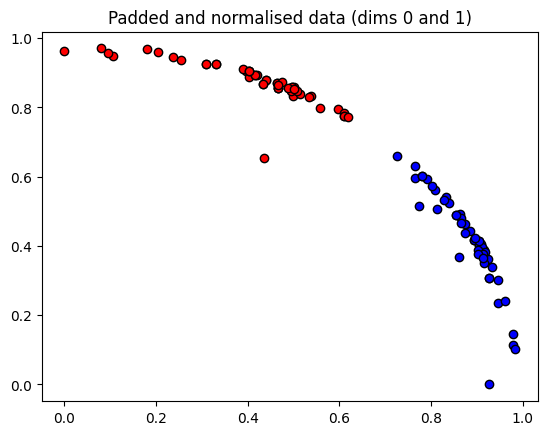

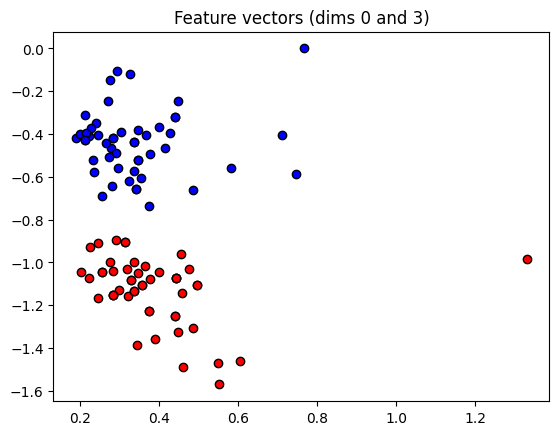

In [46]:
# Scatter plot of original data
plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

# Scatter plot of padded and normalized data
plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

# Scatter plot of the feature vectors
plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

Now, we want to take our model to the next level by enabling it to make predictions on unseen data. To achieve this, we'll train our model on one dataset and evaluate its performance on a separate dataset that it hasn't seen before. This is known as generalization. To keep track of how well our model generalizes, we'll divide our data into two subsets: a training set for model training and a validation set for performance monitoring.

In [47]:
# Set random seed for reproducibility
np.random.seed(0)

num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# Training and validation data that we'll use later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

**Optimization**

First, we initialize the variables.

In [51]:
# Initialize width and number of layers
num_qubits = 2
num_layers = 6

# Initialize weights and bias
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

As before, we'll use the imported NesterovMomentumOptimizer to minimize the cost function.

In [52]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.7368859 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.3059771 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 1.0127180 | Acc train: 0.4533333 | Acc validation: 0.5600000
Iter:     8 | Cost: 0.9626724 | Acc train: 0.6266667 | Acc validation: 0.6000000
Iter:    10 | Cost: 0.9504692 | Acc train: 0.6533333 | Acc validation: 0.6800000
Iter:    12 | Cost: 0.9427522 | Acc train: 0.6266667 | Acc validation: 0.6400000
Iter:    14 | Cost: 0.9271520 | Acc train: 0.5866667 | Acc validation: 0.5200000
Iter:    16 | Cost: 0.8850338 | Acc train: 0.6933333 | Acc validation: 0.6400000
Iter:    18 | Cost: 0.8584185 | Acc train: 0.8133333 | Acc validation: 0.9200000
Iter:    20 | Cost: 0.8416633 | Acc train: 0.7866667 | Acc validation: 0.8000000
Iter:    22 | Cost: 0.7904446 | Acc train: 0.8933333 | Acc validation: 0.9200000
Iter:    24 | Cost: 0.7366709 | Acc train: 0.9066667 | Acc validation: 0.9200000
Iter:    26 | Cost: 0.679616

Using the variational classifier, we can plot the continuous output for the first two dimensions of the Iris dataset.

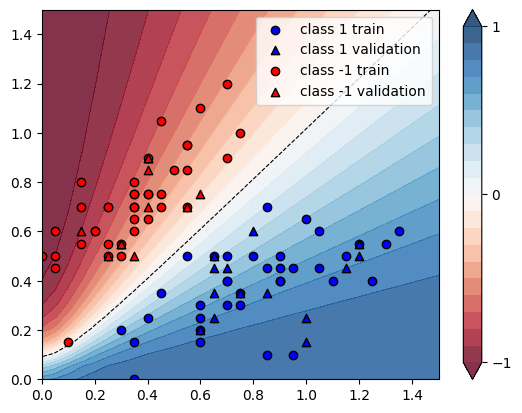

In [53]:
plt.figure()
cm = plt.cm.RdBu

# Make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# Preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# Plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# Plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()